Realizo un Pip install de mi tensoflow para asegurarme de que estoy trbajando con la ultima version de este, asi como para evitar cualquier problema con algunas de sus librerias

In [1]:
!pip3 install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 18 kB/s 
     |████████████████████████████████| 1.7 MB 56.7 MB/s 
     |████████████████████████████████| 438 kB 58.7 MB/s 
     |████████████████████████████████| 5.9 MB 46.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [2]:
#Importo y reviso la version de mi tensorflow
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Modulo_2"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Modulo_2
/content/drive/MyDrive/Modulo_2


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import random as rn
from keras.utils import to_categorical

K.clear_session() #Revisa si existe ya una sesion de Keras, para poder cerrarla y que no haya problemas en esta sesion

In [24]:
anime_girl_names = ['Yor Forger', 'Marin Kitagawa', 'Micchon Shikimori']

X = []
Z = []
img_size = 250

In [25]:
def make_train_data(name, DIR):
  for img in tqdm(os.listdir(DIR)):
    label = name
    path = os.path.join(DIR, img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    X.append(np.array(img))
    Z.append(str(label))

In [26]:
i = 1
for girl in anime_girl_names:
  dir = './Anime_Girls/' + girl
  make_train_data(girl, dir)
  print(i , ' :' , len(X))
  i = i + 1

100%|██████████| 62/62 [00:01<00:00, 44.79it/s]


1  : 62


100%|██████████| 64/64 [00:01<00:00, 38.78it/s]


2  : 126


100%|██████████| 59/59 [00:15<00:00,  3.79it/s]

3  : 185


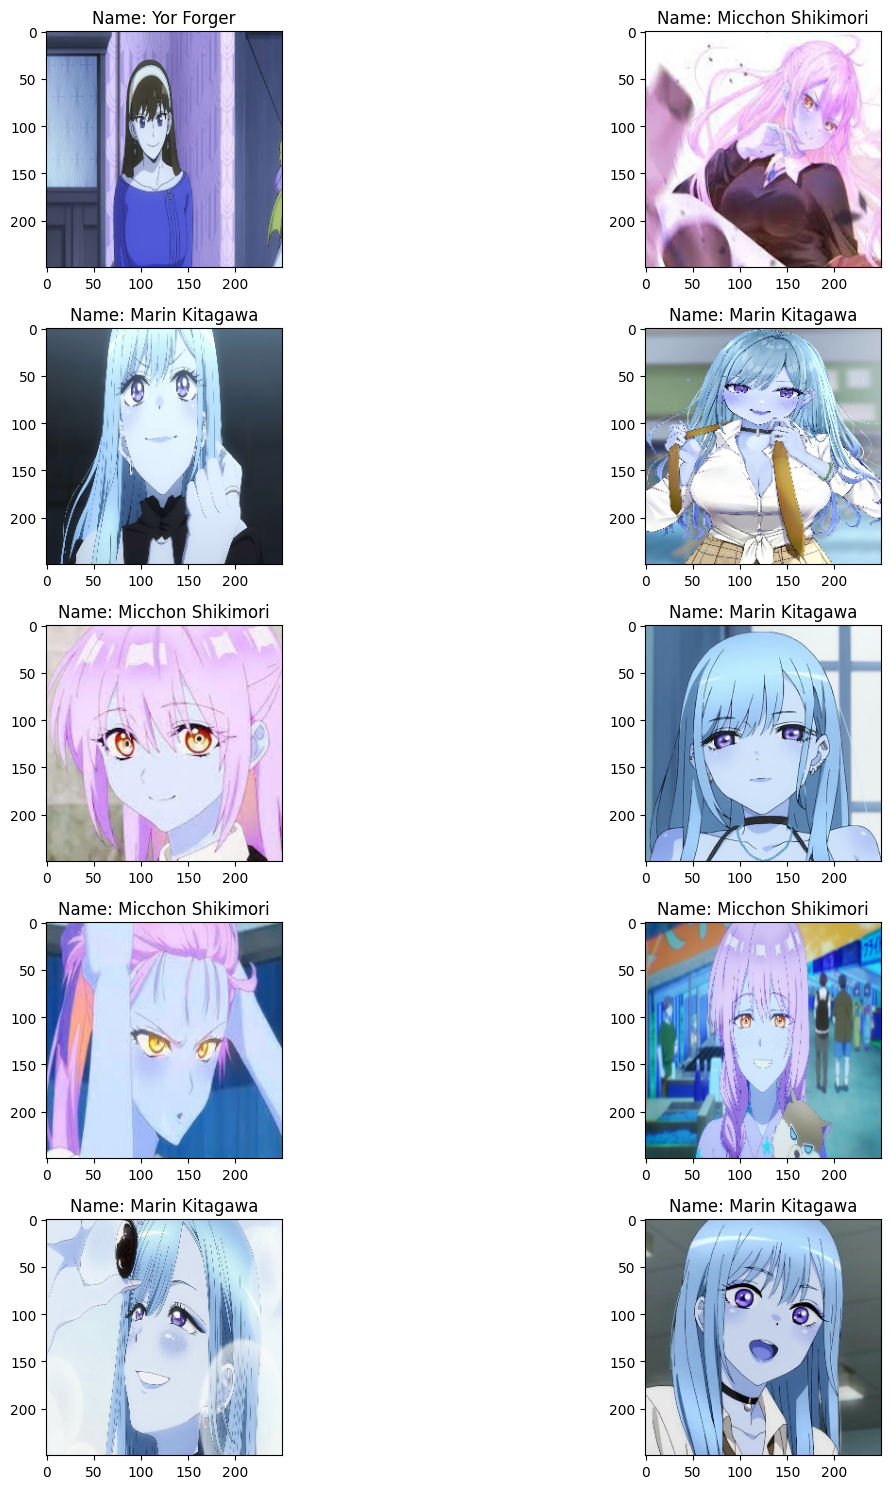

In [27]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Name: '+Z[l])
        
plt.tight_layout()

In [28]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,3)
X=np.array(X)
X=X/250

In [29]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=42)

In [30]:
#Parametro para red neuronal
epochs = 15 #Numero de veces que se iterara nuestro set de datos
heigth, width = 250, 250 #Tamaño al que se procesaran las imagenes de nuestra database 100px x 100px 
batch_size = 5 #Numero de imagenes que procesara en cada paso
steps_per_epoch = 5 #Numero de veces que se procesara la informacion en cada epoca
v_steps = 25 #Numero de veces que porcesaran con nuestros datos de Validacion

#Numero de filtros de cada convolucion, siendo esto la profundidad de nuestra imagen
convolution_1 = 32
convolution_2 = 64

#Tamaño de cada convolucion
size_convolution_1 = (3,3)
size_convolution_2 = (2,2)

#Tamaño que se usara para el MaxPooling
MaxPooling2D_size = (2,2)

#Numero de clases con las que se va trabajar, en mi clase son 10 ya que se entrenara la red para que esta pueda indentificar a 10 peronajes distintos
classN = 3

#Tamaño de ajuste de nuestra red neuronal (mientras mas pequeño mejor)
lr = 0.0005

In [33]:
#Prepocesamiento de imagenes
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  #Genera imagenes con rotacion, para que el modelo pueda aprender a identificar imagenes en distintas posiciones
        zoom_range = 0.1,  #Genera imagenes con zoom, para que el modelo pueda aprender a identificar imagenes en distintas posiciones
        width_shift_range=0.2,  #Genera imagenes con distinto tamaño, para que el modelo pueda aprender a identificar imagenes en distintas posiciones
        height_shift_range=0.2,  
        horizontal_flip=True,   #Genera imagenes con Invertidas, para que el modelo pueda aprender a identificar imagenes en distintas posiciones
        vertical_flip=False)  
datagen.fit(x_train)

In [34]:
#Se crea nuestra Red Neuronal Convulocional

cnn = Sequential() #Se indica que nuestra red es secuancial, ya que son varias capas apiladas entre ellas

#Agregamos la primera capa de convolucion
cnn.add(Convolution2D(convolution_1, 
                        size_convolution_1,
                        padding='same',
                        input_shape=(heigth, width, 3), #Input shape normalmente solo se agrega en la primera capa de la red
                        activation='relu'))

cnn.add(MaxPooling2D(pool_size= MaxPooling2D_size))

#Agregamos la segunda capa de convolucion
cnn.add(Convolution2D(convolution_2, 
                        size_convolution_2,
                        padding='same', 
                        activation='relu'))

cnn.add(MaxPooling2D(pool_size= MaxPooling2D_size))

cnn.add(Flatten()) #Aqui se trabaja con la imagen despues de su proceso la vamos a volver plana osea que unicamente nos vamos a quedar con una dimension, que tendra toda la informaccion de nuestra red neuronal

cnn.add(Dense(256, activation= 'relu')) #Una nueva capa con 256 neuronas y con activacion relu

cnn.add(Dropout(0.5)) #Se agrega DropOut para evitar sobre ajustar nuestra red neuronal

cnn.add(Dense(classN, activation='softmax')) #SoftMax nos ayudara a darnos un porcentaje de que tanta probabilidad hay de que la imagen sea un personaje

cnn.summary() #Imprimo un resumen del modelo


cnn.compile(loss='categorical_crossentropy', #Ya que recordemos que nuestra red neuronal es categorica
            optimizer=optimizers.Adam(lr=lr), #Nuesto optimizador tiene un learning rate que difinimos en nuestra variabes de arriba
            metrics=['accuracy']) #Utiliza como metrica el procentaje de que tan bien esta aprendiendo nuestra red neuronal

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 256)               6

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
4/4 [==============================] - 16s 4s/step - loss: 12.7469 - accuracy: 0.3495 - val_loss: 15.4835 - val_accuracy: 0.2308
Epoch 2/15
4/4 [==============================] - 11s 2s/step - loss: 10.4762 - accuracy: 0.3592 - val_loss: 6.4909 - val_accuracy: 0.3846
Epoch 3/15
4/4 [==============================] - 9s 2s/step - loss: 6.2541 - accuracy: 0.3301 - val_loss: 3.1224 - val_accuracy: 0.2308
Epoch 4/15
4/4 [==============================] - 9s 2s/step - loss: 2.9517 - accuracy: 0.4854 - val_loss: 0.8693 - val_accuracy: 0.6538
Epoch 5/15
4/4 [==============================] - 9s 2s/step - loss: 1.4145 - accuracy: 0.6311 - val_loss: 0.3561 - val_accuracy: 0.9231
Epoch 6/15
4/4 [==============================] - 9s 2s/step - loss: 0.3353 - accuracy: 0.8641 - val_loss: 0.5523 - val_accuracy: 0.7308
Epoch 7/15
4/4 [==============================] - 9s 2s/step - loss: 0.2969 - accuracy: 0.8932 - val_loss: 0.2494 - val_accuracy: 0.9231
Epoch 8/15
4/4 [====================

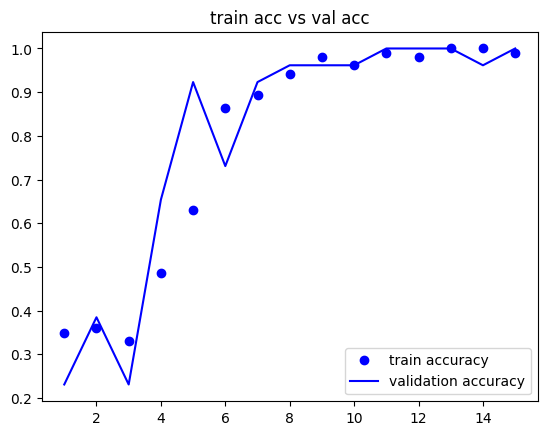

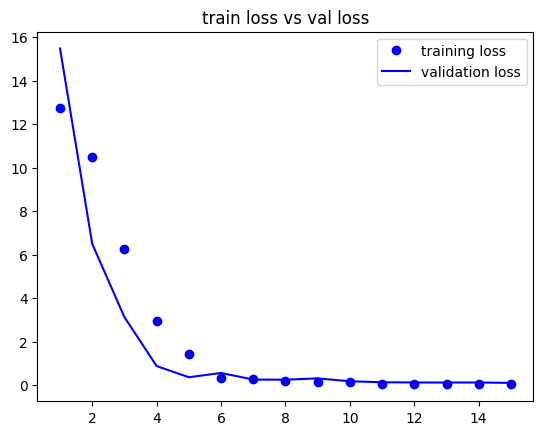

In [35]:
#Para entrenar nuestro algoritmo havemo uso de fit (Que significa cada variable se describe en la parte de parametros)
history = cnn.fit(x_train,y_train, epochs = epochs, validation_split = 0.2)


#Procedo a guardar mi modelo
cnn.save('Model_Anime_Girls_best.h5')
cnn.save_weights('Model_Anime_Girls_pesos.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [36]:
score_model1 = cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss Model 2:', score_model1[0])
print('Test accuracy Model 2:', score_model1[1])

Test loss Model 2: 0.11337532103061676
Test accuracy Model 2: 0.9642857313156128


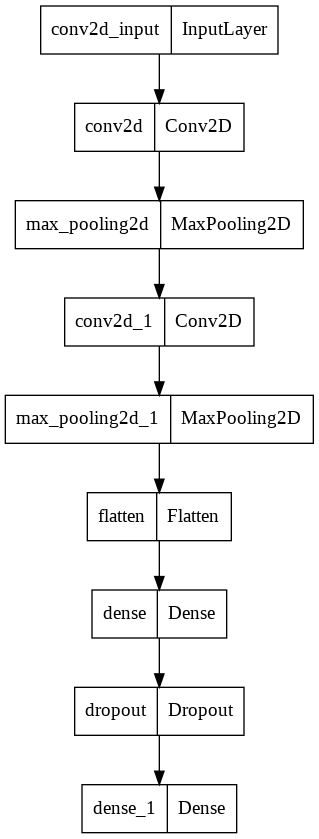

In [45]:
from keras.utils import plot_model
plot_model(cnn)

In [37]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(axis = 1), cnn.predict(x_test).argmax(axis=1))
matrix

2/2 [==============================] - 1s 520ms/step


array([[20,  0,  0],
       [ 0, 15,  0],
       [ 1,  1, 19]])

2/2 [==============================] - 1s 496ms/step


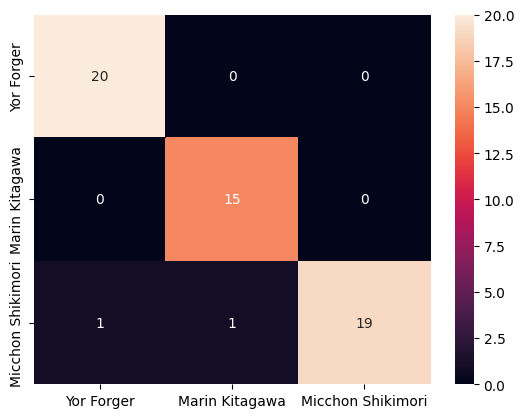

In [38]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

mat = confusion_matrix(y_test.argmax(axis = 1), cnn.predict(x_test).argmax(axis=1))


m_confusion = sns.heatmap(mat, annot=True,xticklabels=anime_girl_names,yticklabels=anime_girl_names)

fig = m_confusion.get_figure()
fig.savefig("matrix_confusion.png") 

In [39]:
#Modelo anterior con Transfer learning

conv_base= VGG16(weights='imagenet',
								include_top=False,
								input_shape = (heigth, width,3))
								
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(3,activation='sigmoid'))

model.summary()

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
10/10 [==============================] - 85s 9s/step - loss: 1.0325 - acc: 0.4757 - val_loss: 0.8935 - val_acc: 0.5769
Epoch 2/10
10/10 [==============================] - 77s 8s/step - loss: 0.5763 - acc: 0.9029 - val_loss: 0.7401 - val_acc: 0.8462
Epoch 3/10
10/10 [==============================] - 72s 7s/step - loss: 0.3942 - acc: 0.9709 - val_loss: 0.6409 - val_acc: 0.7692
Epoch 4/10
10/10 [==============================] - 78s 8s/step - loss: 0.2765 - acc: 0.9806 - val_loss: 0.6162 - val_acc: 0.7692
Epoch 5/10
10/10 [==============================] - 72s 7s/step - loss: 0.1963 - acc: 0.9903 - val_loss: 0.6059 - val_acc: 0.6923
Epoch 6/10
10/10 [==============================] - 72s 7s/step - loss: 0.1469 - acc: 0.9903 - val_loss: 0.4386 - val_acc: 0.8846
Epoch 7/10
10/10 [==============================] - 78s 8s/step - loss: 0.0974 - acc: 1.0000 - val_loss: 0.4349 - val_acc: 0.8462
Epoch 8/10
10/10 [==============================] - 72s 7s/step - loss: 0.0719 - acc: 1.00

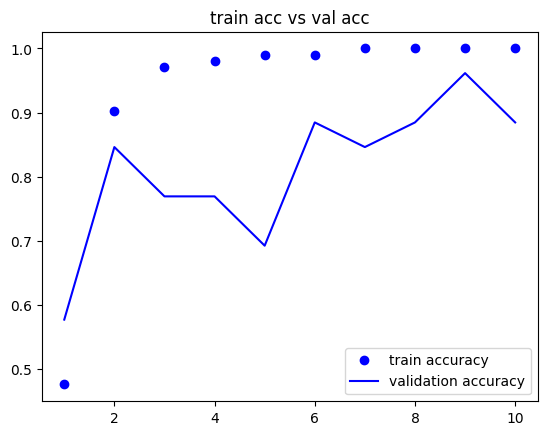

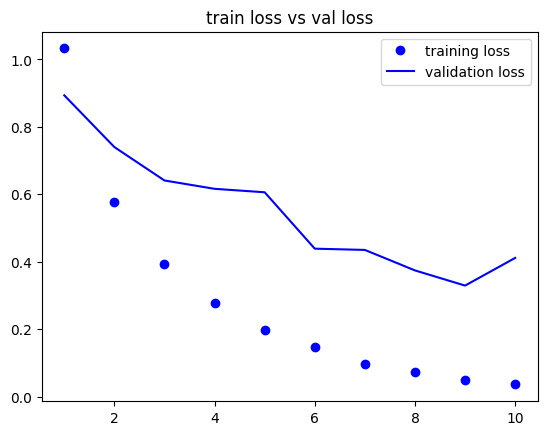

In [40]:
history2 = model.fit(x_train,y_train, 
				steps_per_epoch = 10,  
				epochs = 10, 
				validation_split = 0.2, 
				validation_steps = 5)


				
model.save('Model_Anime_Girls.h5')
			
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [41]:
#Calculo el error de mi modelo
score_model2 = model.evaluate(x_test, y_test, verbose=0)
print('Test loss Model 2:', score_model2[0])
print('Test accuracy Model 2:', score_model2[1])

Test loss Model 2: 0.1983238011598587
Test accuracy Model 2: 0.9642857313156128


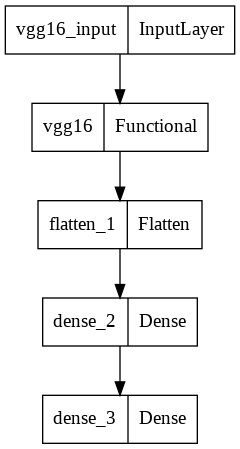

In [44]:
plot_model(model)